In [2]:
# based off https://umap-learn.readthedocs.io/en/latest/parameters.html
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import umap
%matplotlib inline

sns.set(style='white', context='poster', rc={'figure.figsize':(14,10)})

#make 4 dim data (R,G,B, tranlucency)
np.random.seed(42)
data = np.random.rand(800,4)

#low dim rep of data fit_transform-> learn manifold from data and then apply that to the data
fit = umap.UMAP()
%time u = fit.fit_transform(data)
#u is the 2d representation of the data

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


CPU times: user 11.4 s, sys: 270 ms, total: 11.7 s
Wall time: 6.94 s


Text(0.5, 1.0, 'UMAP Embedding of Random Colors')

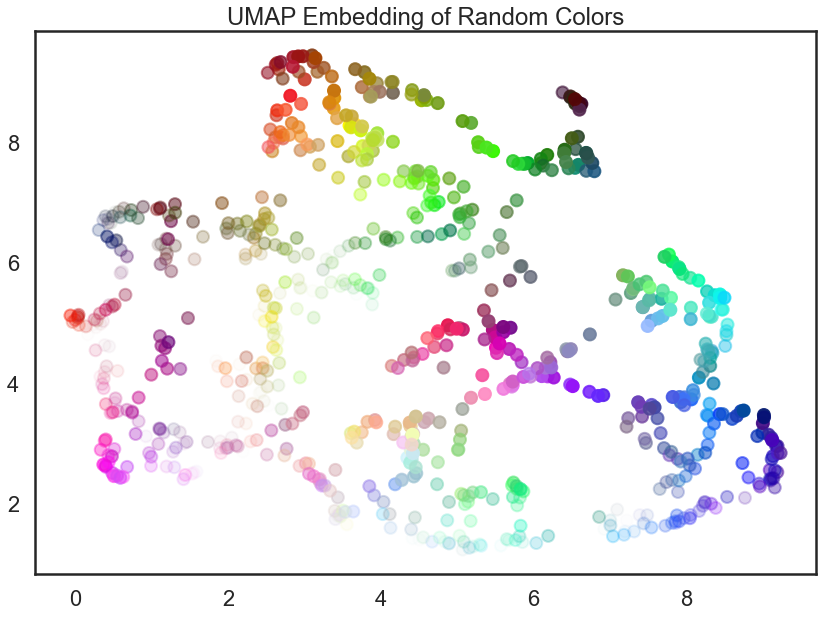

In [5]:
plt.scatter(u[:,0], u[:,1], c=data)
plt.title("UMAP Embedding of Random Colors")

n_neighbors, min_dist, n_components, metric are the four major UMAP hyperparameters that affect the resulting embedding

/opt/anaconda3/lib/python3.9/site-packages/umap/spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


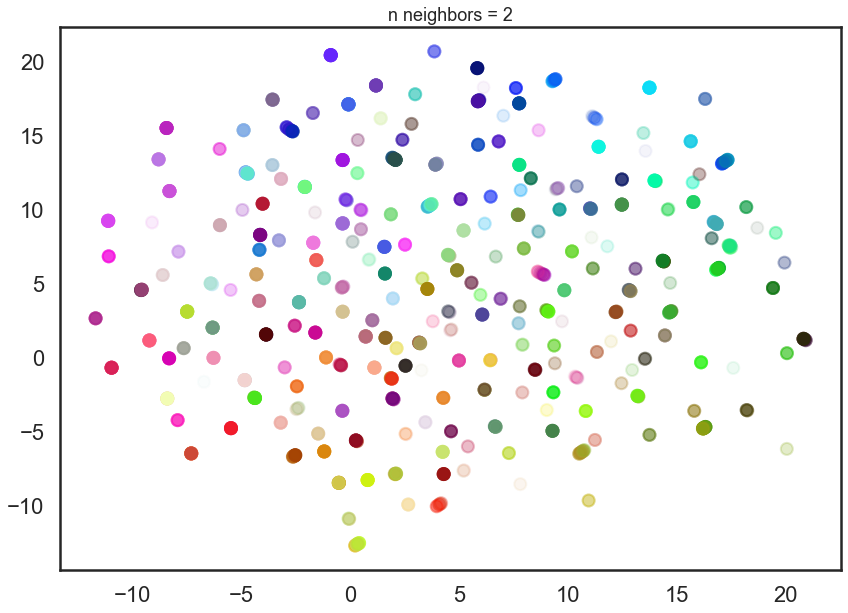

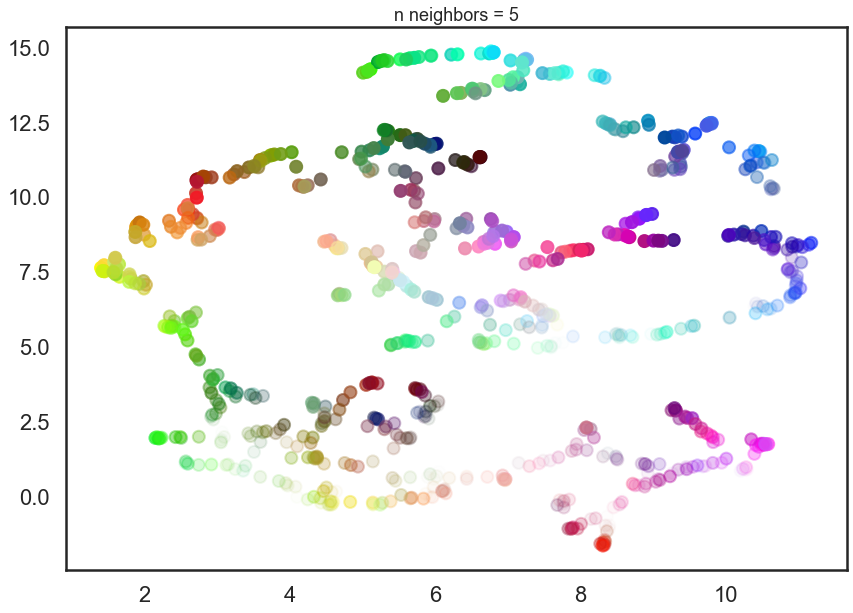

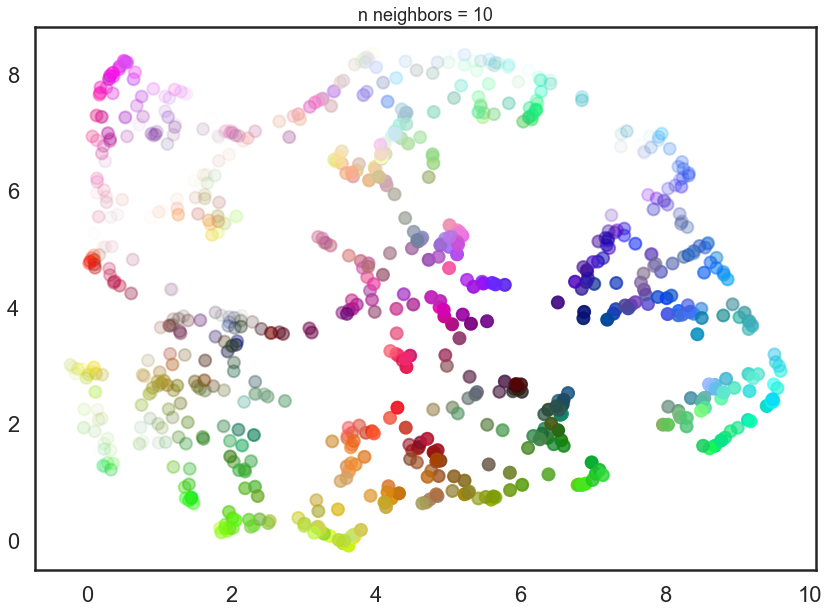

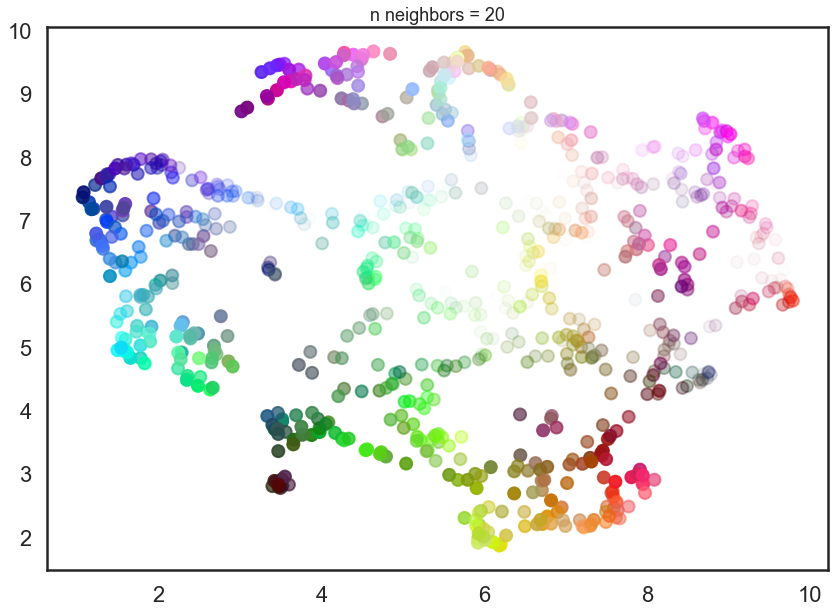

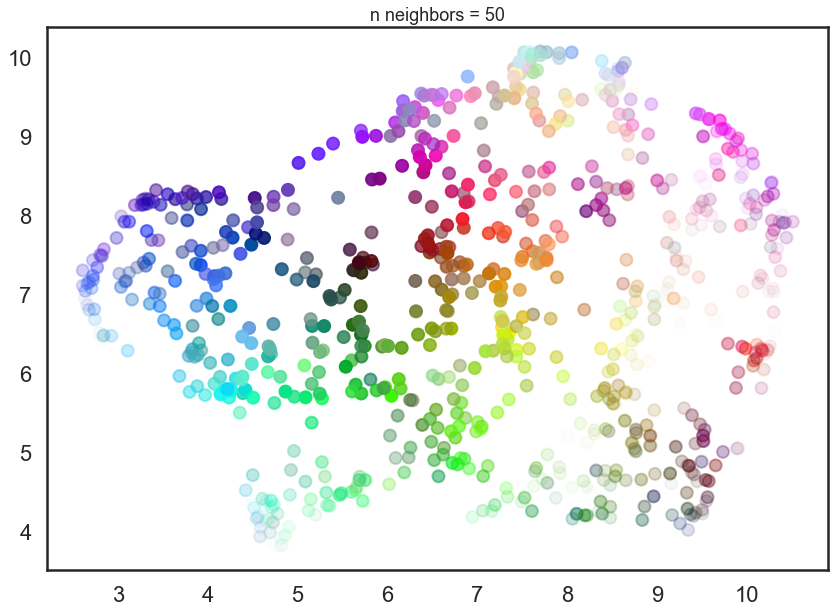

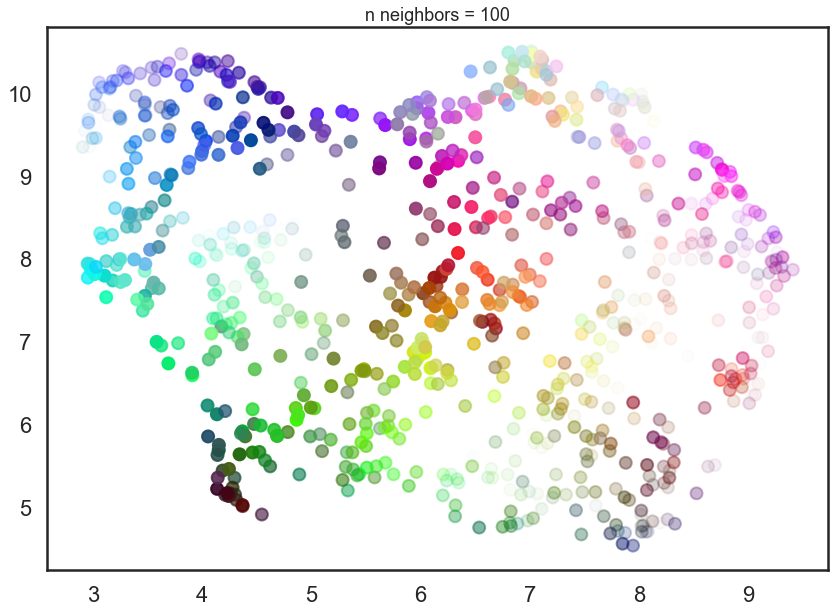

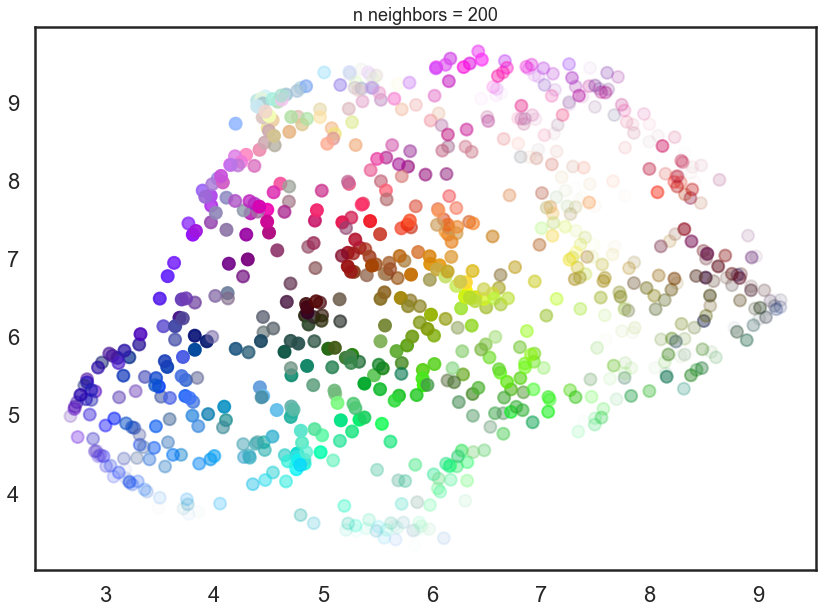

In [8]:
def draw_umap(n_neighbors=15, min_dist=0.1, n_components=2, metric='euclidean', title = ''):
    fit = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist = min_dist,
        n_components=n_components,
        metric=metric,
    )
    u = fit.fit_transform(data);
    fig = plt.figure()
    if n_components ==1:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], range(len(u)), c = data)
    if n_components == 2:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], u[:,1], c = data)
    if n_components ==3:
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(u[:,0],u[:,1], u [:,2], c=data, s=100)
    plt.title(title, fontsize=18)

for n in (2,5,10,20,50,100,200):
    draw_umap(n_neighbors=n, title='n neighbors = {}'.format(n))

Low values of n_neighbors force umap to look at very local structure while high values of n_neighbors force umap to look at data with braoder picture in mind. 

default n_neighbors = 15

n_neighbors = 2 -> we see that we have almost singletons of colors closest to each other

n_neighbors = 200 -> we see luminance well defined but color matches are not necessarily the closest to each other -> broader structure of data found at the expense of fine detail 

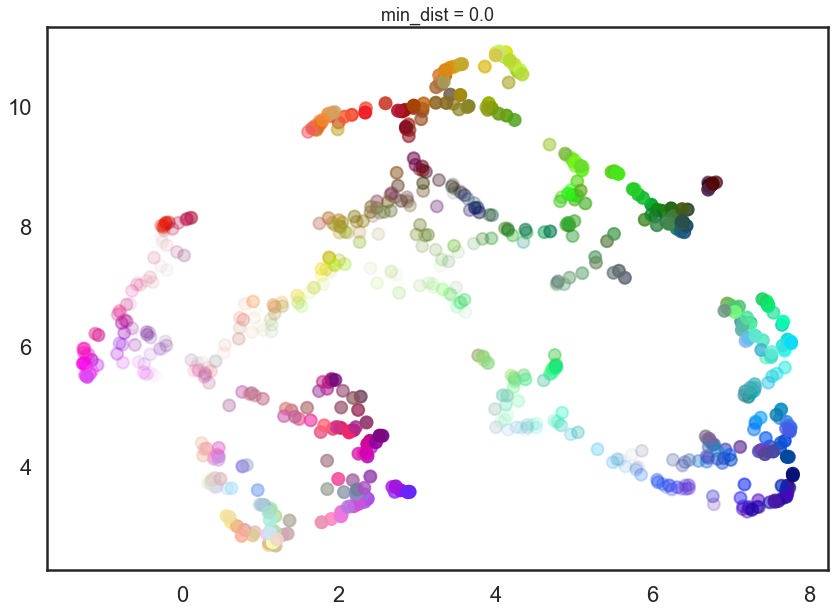

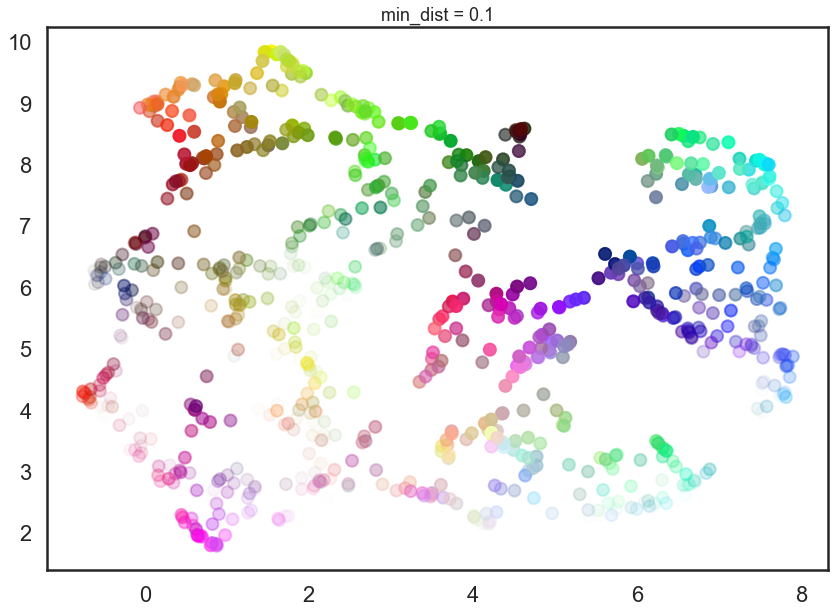

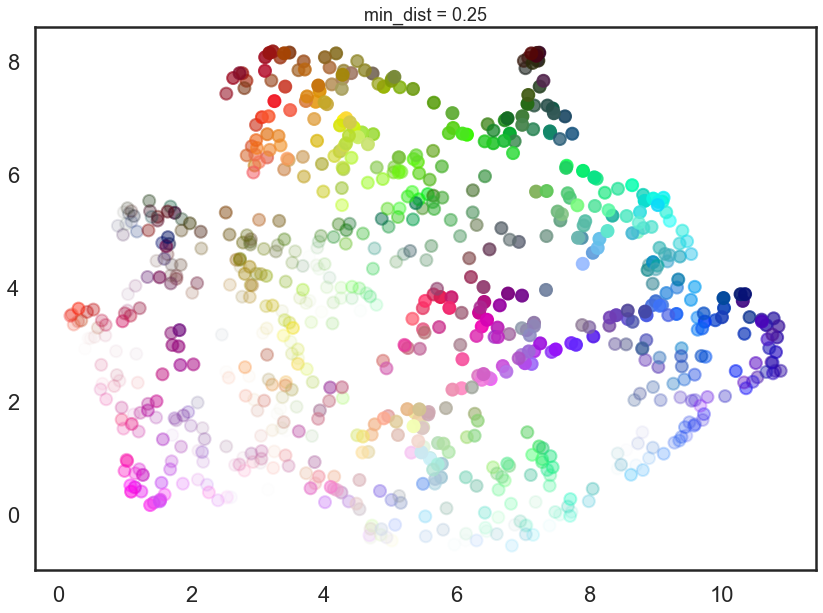

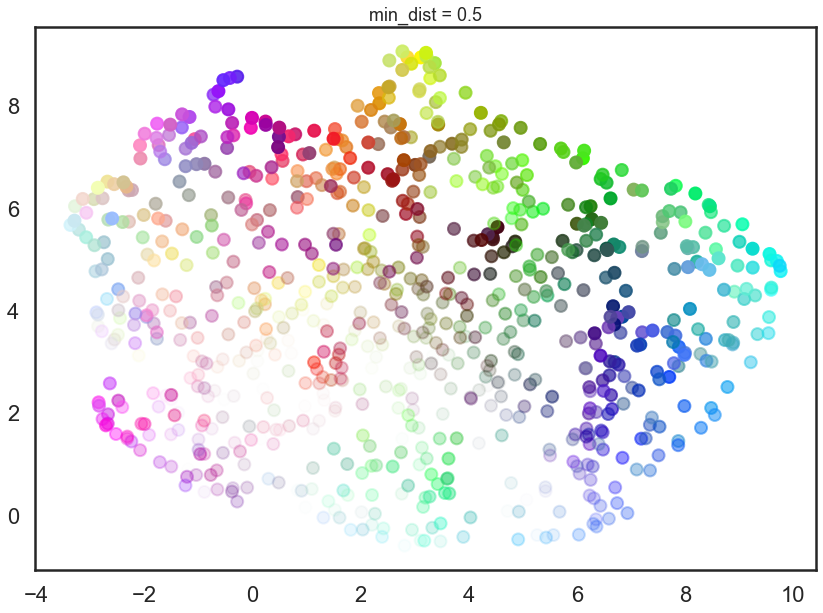

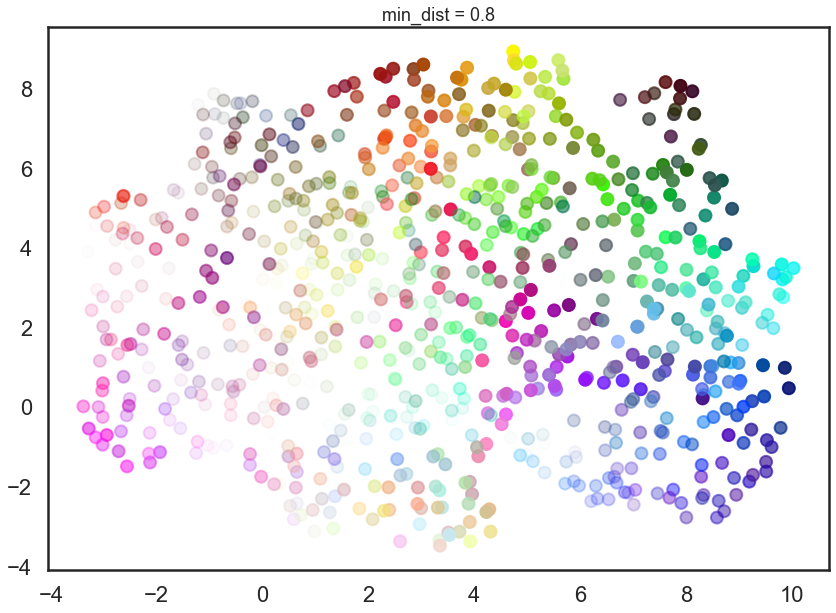

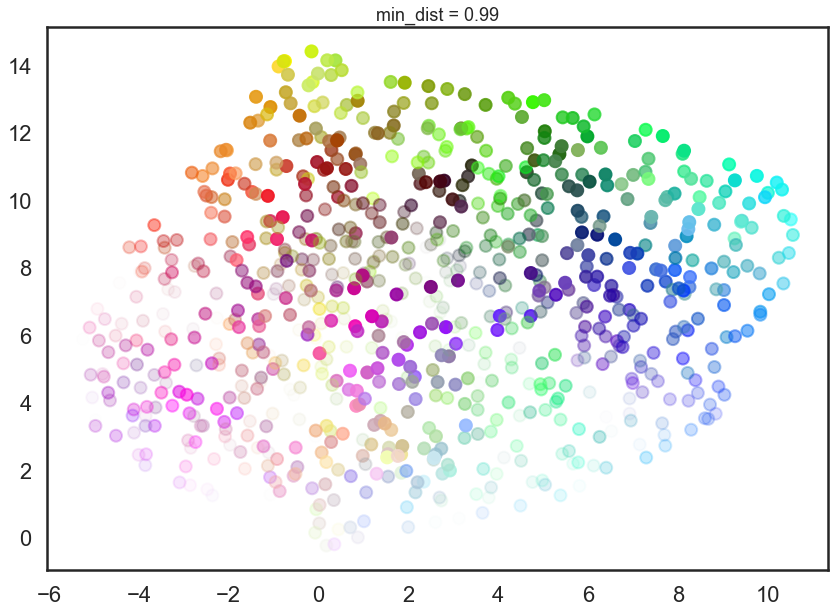

In [10]:
for d in (0.0, 0.1, 0.25, 0.5, 0.8, 0.99):
    draw_umap(min_dist=d, title='min_dist = {}'.format(d))

min_dist literally the min dist points can be. Default values are 0.1, low value gives more clumpier embeddings, bigger ones preserve structure, but imo does not really seem as meaningful.

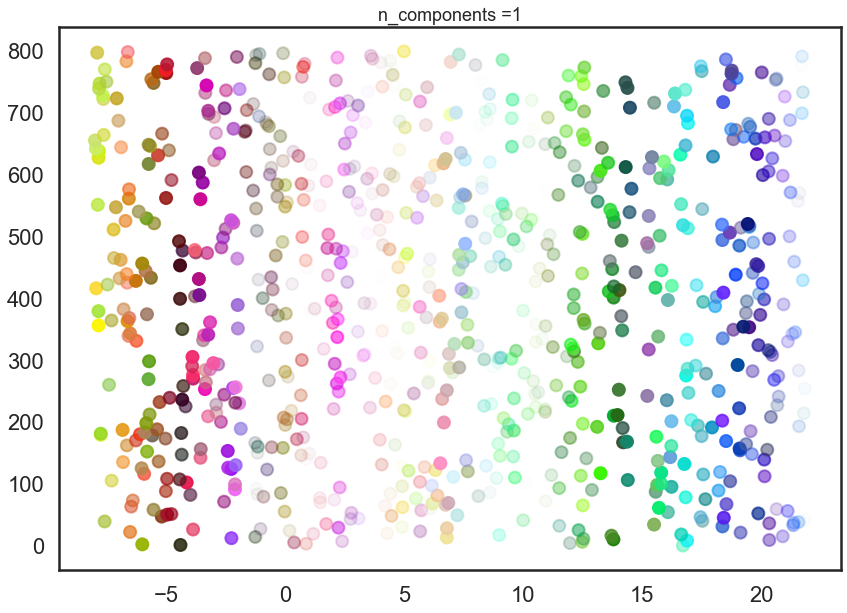

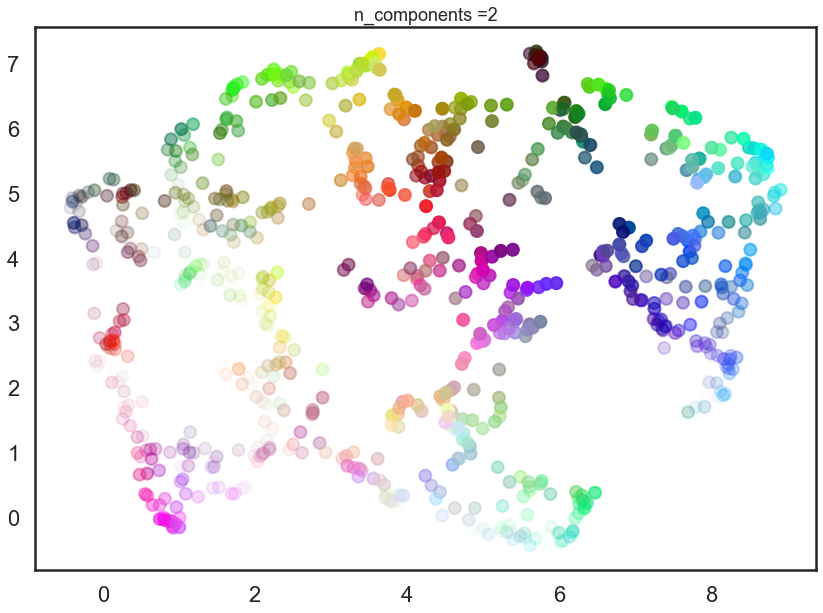

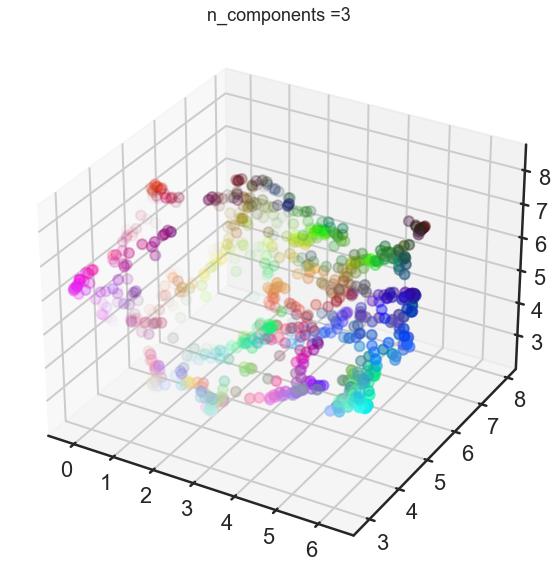

In [12]:
for n in (1, 2, 3):
    draw_umap(n_components=n, title='n_components ={}'.format(n))

n_components is the number of dimensions we are reducing to. Default is 2 but can do more than 3 as well. Is this the same as the number of clusters ?

# metric
umap supports any metric and also custom user defined metrics as long as those metrics can be compiled in nopython mode by numba

euclidean
euclidean
CPUDispatcher(<function red_channel_dist at 0x7fd477e151f0>)
red_channel_dist


/opt/anaconda3/lib/python3.9/site-packages/umap/umap_.py:1772: UserWarning: custom distance metric does not return gradient; inverse_transform will be unavailable. To enable using inverse_transform method, define a distance function that returns a tuple of (distance [float], gradient [np.array])
  warn(


CPUDispatcher(<function sl_dist at 0x7fd4790e4e50>)
sl_dist


/opt/anaconda3/lib/python3.9/site-packages/umap/umap_.py:1772: UserWarning: custom distance metric does not return gradient; inverse_transform will be unavailable. To enable using inverse_transform method, define a distance function that returns a tuple of (distance [float], gradient [np.array])
  warn(


CPUDispatcher(<function hue_dist at 0x7fd4790e44c0>)
hue_dist


/opt/anaconda3/lib/python3.9/site-packages/umap/umap_.py:1772: UserWarning: custom distance metric does not return gradient; inverse_transform will be unavailable. To enable using inverse_transform method, define a distance function that returns a tuple of (distance [float], gradient [np.array])
  warn(


CPUDispatcher(<function hsl_dist at 0x7fd4790e4a60>)
hsl_dist


/opt/anaconda3/lib/python3.9/site-packages/umap/umap_.py:1772: UserWarning: custom distance metric does not return gradient; inverse_transform will be unavailable. To enable using inverse_transform method, define a distance function that returns a tuple of (distance [float], gradient [np.array])
  warn(


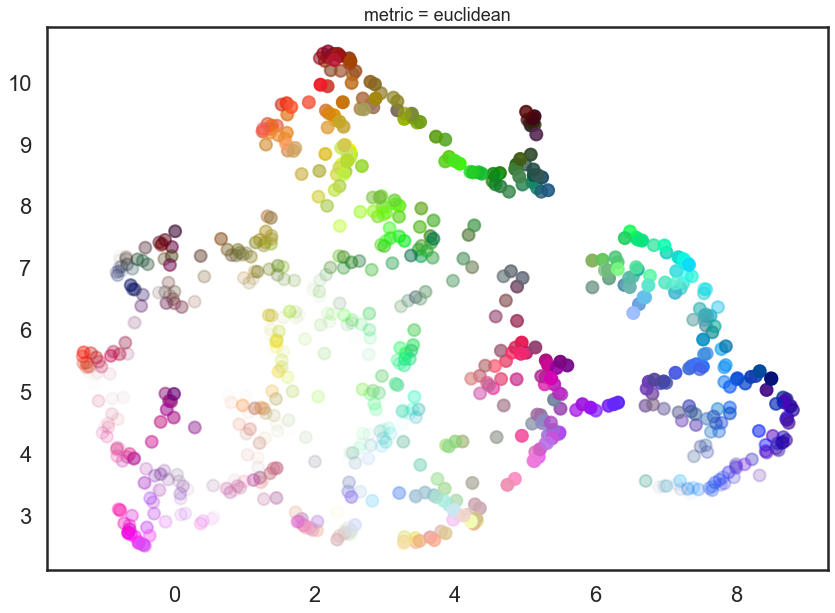

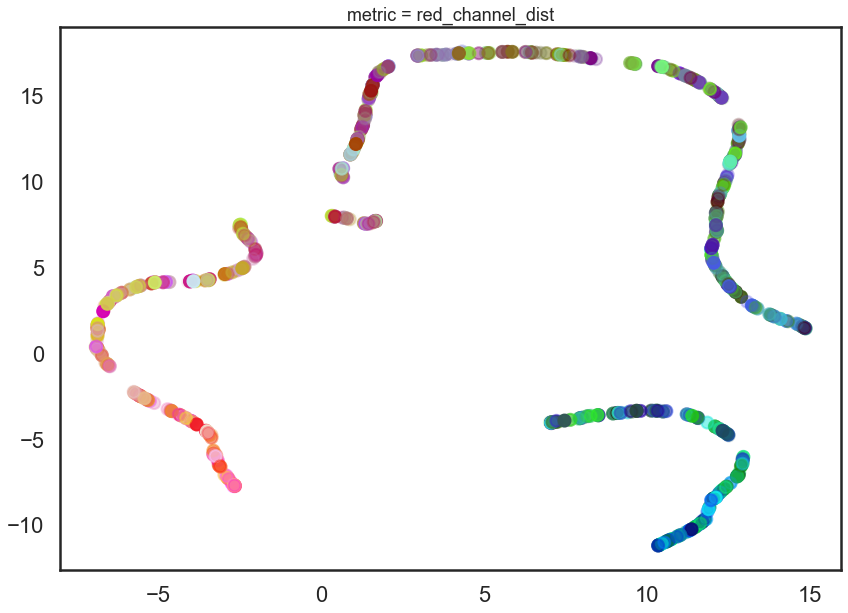

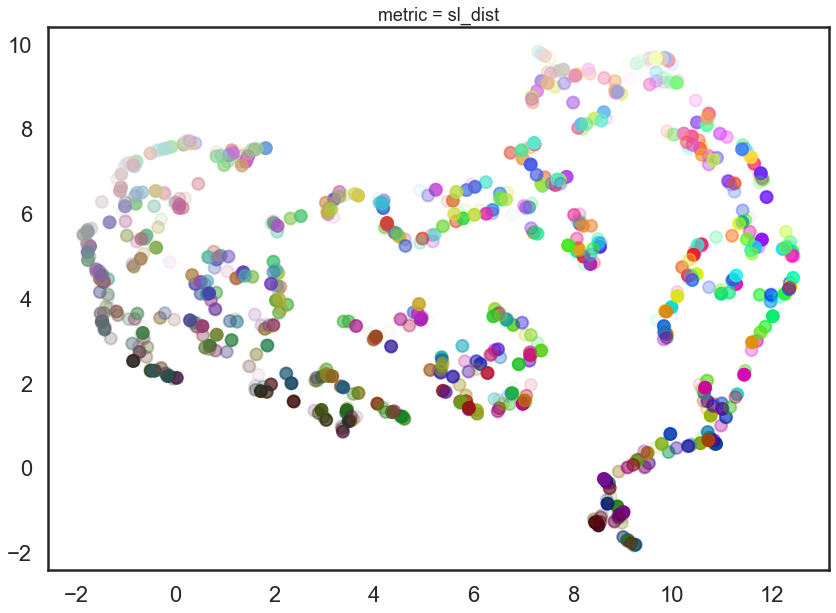

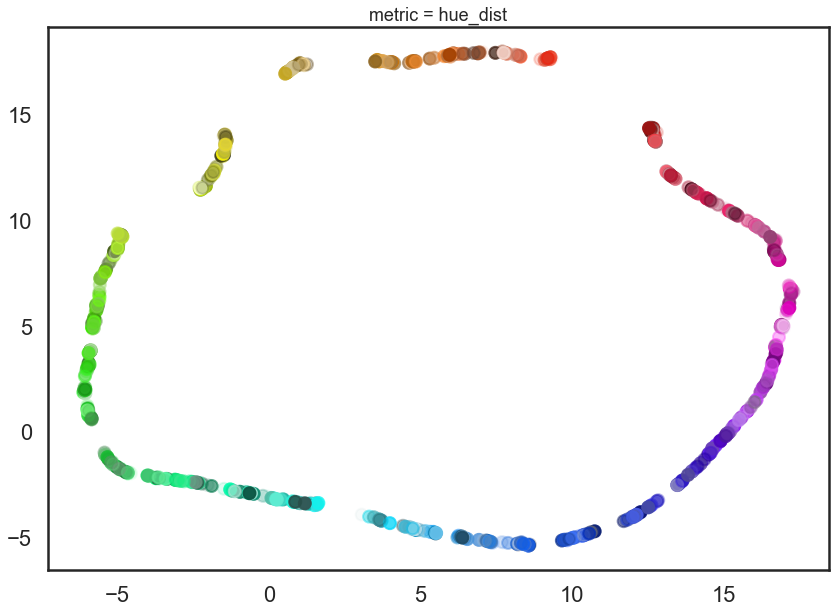

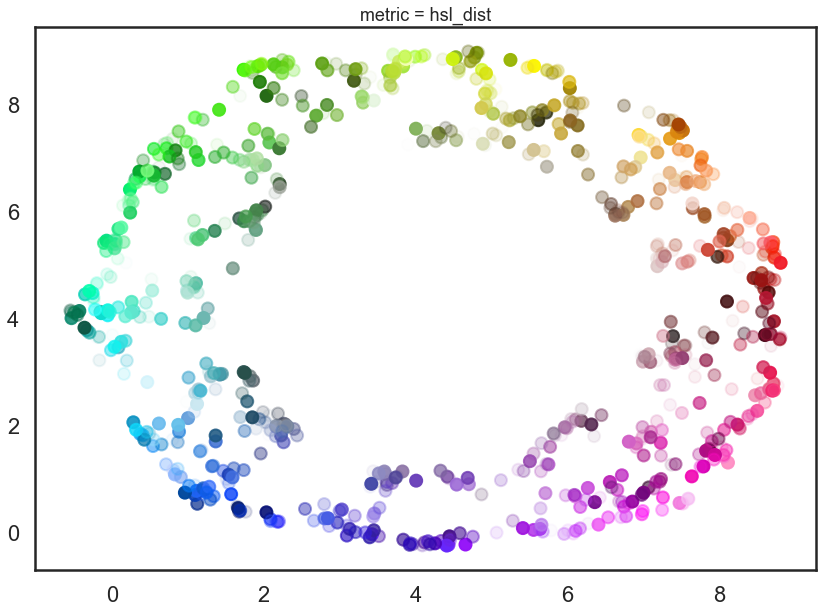

In [26]:
#numba applies a jit compiler to transform python code which is compiled line by line into machine code for a whole function
import numba
#first custom metric: distance = absval of difference in red channel
@numba.njit()
def red_channel_dist(a,b):
    return np.abs(a[0] - b[0])

@numba.njit()
def hue (r,g,b):
    cmax = max(r,g,b)
    cmin = min(r,g,b)
    delta = cmax-cmin
    if cmax == r:
        return ((g-b)/delta) %6
    elif cmax == g:
        return ((b-r)/delta)+2
    else: 
        return ((r-g)/delta)+4

@numba.njit()
def lightness(r,g,b):
    cmax = max(r,g,b)
    cmin = min(r,g,b)
    return (cmax +cmin)/ 2.0

@numba.njit()
def saturation(r,g,b):
    cmax = max(r,g,b)
    cmin = min(r,g,b)
    chroma = cmax-cmin
    light = lightness(r,g,b)
    if light ==1:
        return 0
    else:
        return chroma/(1-abs(2*light-1))

#difference in hue metric
@numba.njit()
def hue_dist(a,b):
    diff = (hue(a[0], a[1], a[2])- hue(b[0], b[1],b[2])) %6
    if diff <0:
        return diff +6
    else:
        return diff

@numba.njit()
def sl_dist(a,b):
    a_sat = saturation(a[0], a[1], a[2])
    b_sat = saturation(b[0], b[1], b[2])
    a_light = lightness(a[0], a[1], a[2])
    b_light = lightness(b[0], b[1], b[2])
    return (a_sat - b_sat)**2 + (a_light - b_light)**2

@numba.njit()
def hsl_dist(a,b):
    a_sat = saturation(a[0], a[1], a[2])
    b_sat = saturation(b[0], b[1], b[2])
    a_light = lightness(a[0], a[1], a[2])
    b_light = lightness(b[0], b[1], b[2])
    a_hue = hue(a[0], a[1], a[2])
    b_hue = hue(b[0], b[1], b[2])
    return (a_sat - b_sat)**2 +(a_light - b_light)**2 + (((a_hue - b_hue)%6)/6.0)

# now test with the different metrics 
for m in ("euclidean", red_channel_dist, sl_dist, hue_dist, hsl_dist):
    name = m if type(m) is str else m.__name__
    draw_umap(n_components = 2, metric = m, title= 'metric = {}'.format(name))

Red channell gives one dimensional manifold
Hue gives a circle 
HSL fattens circle